In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
from google.colab import drive

# Google Drive bağlantısı
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Veri seti yolu
data_dir = "/content/drive/MyDrive/dataset/archive (4)"
categories = ["yes", "no"]
IMG_SIZE = 180  # MRI görüntülerini boyutlandırma

def load_data():
    X, y = [], []
    for category in categories:
        path = os.path.join(data_dir, category)
        if not os.path.exists(path):
            print(f"Dizin bulunamadı: {path}")
            continue
        label = categories.index(category)
        for img_name in os.listdir(path):
            try:
                img_path = os.path.join(path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                X.append(img / 255.0)
                y.append(label)
            except Exception as e:
                print(f"Hata: {e}")
    return np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1), np.array(y)


In [8]:
# Veriyi yükleme
X, y = load_data()
if len(X) == 0:
    raise ValueError("Veri yüklenemedi, lütfen dosya yollarını kontrol edin.")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
# Veri artırma işlemi
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)


In [10]:
# Model oluşturma
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
# Modeli derleme
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Modeli eğitme
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(datagen.flow(X_train, y_train, batch_size=16), validation_data=(X_test, y_test), epochs=60, callbacks=[early_stopping])


Epoch 1/60


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 422ms/step - accuracy: 0.4457 - loss: 1.2118 - val_accuracy: 0.5294 - val_loss: 0.6720
Epoch 2/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.6084 - loss: 0.6467 - val_accuracy: 0.5294 - val_loss: 0.7498
Epoch 3/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.6643 - loss: 0.6727 - val_accuracy: 0.5686 - val_loss: 0.6397
Epoch 4/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.6772 - loss: 0.6294 - val_accuracy: 0.5490 - val_loss: 0.6531
Epoch 5/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.6903 - loss: 0.5932 - val_accuracy: 0.5686 - val_loss: 0.6191
Epoch 6/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.7118 - loss: 0.6022 - val_accuracy: 0.6078 - val_loss: 0.6072
Epoch 7/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.6684 - loss: 0.6030 - val_accuracy: 0.6471 - val_loss: 0.5797
Epoch 8/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.6728 - loss: 0.6475 - val_accuracy: 0.5490 - val_loss: 

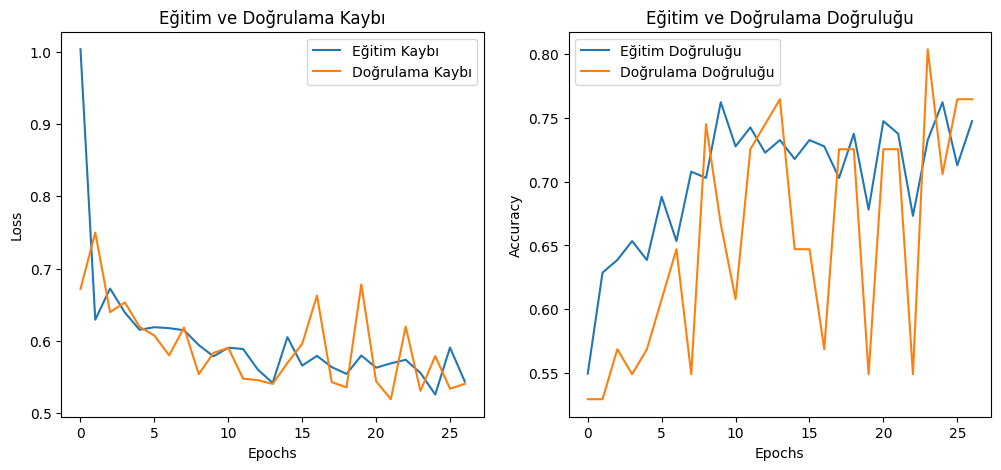

In [12]:

# Eğitim ve doğrulama kayıplarını görselleştirme
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.legend()
plt.show()

In [13]:
# Test sonuçlarını değerlendirme
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step
Accuracy: 0.7254901960784313
F1 Score: 0.7083333333333334
Precision: 0.7083333333333334
Recall: 0.7083333333333334


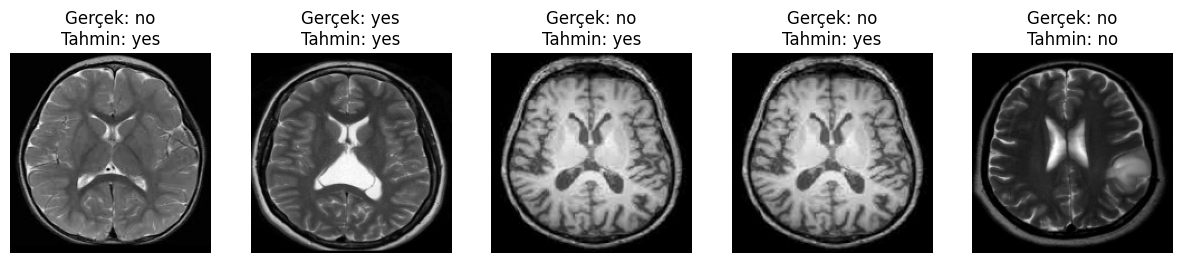

In [14]:
# Test örneklerinden bazılarını görselleştirme
plt.figure(figsize=(15, 5))
for i in range(5):
    idx = np.random.randint(0, len(X_test))
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_test[idx].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
    plt.title(f"Gerçek: {categories[y_test[idx]]}\nTahmin: {categories[y_pred[idx][0]]}")
    plt.axis('off')
plt.show()

Model başarıyla kaydedildi.


Model başarıyla yüklendi.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 332ms/step
Yüklenen Model Accuracy: 0.7254901960784313


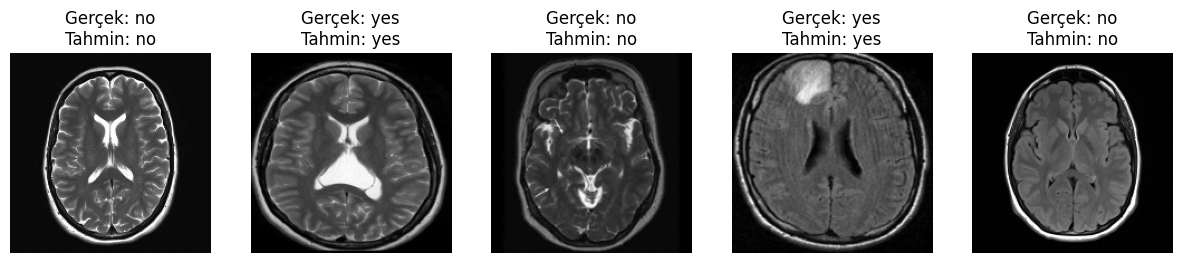

In [15]:
from tensorflow.keras.models import load_model

# Modeli kaydetme
model.save("/content/drive/MyDrive/Colab Notebooks/brain_tumor_detection_model.h5")
print("Model başarıyla kaydedildi.")

# Modeli yükleme
loaded_model = load_model("/content/drive/MyDrive/Colab Notebooks/brain_tumor_detection_model.h5")
print("Model başarıyla yüklendi.")

# Yüklenen model ile test sonuçları
y_pred_loaded = (loaded_model.predict(X_test) > 0.5).astype("int32")
print("Yüklenen Model Accuracy:", accuracy_score(y_test, y_pred_loaded))
plt.figure(figsize=(15, 5))
for i in range(5):
    idx = np.random.randint(0, len(X_test))
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_test[idx].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
    plt.title(f"Gerçek: {categories[y_test[idx]]}\nTahmin: {categories[y_pred[idx][0]]}")
    plt.axis('off')
plt.show()